In [1]:
import os

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
from scipy import stats

%matplotlib inline

### 1. Чтение и подготовка данных

In [2]:
TRAIN_SIZE = 50
ZERO_NEW_CASES_FILL = 1
START_DATE = '2020-03-03'

In [3]:
data_df = pd.read_csv(os.path.join('data', 'owid-covid-data.csv'), usecols=['date', 'total_cases', 'new_cases', 'iso_code'])
data_df = data_df[data_df.iso_code == 'RUS'].copy()
data_df.date = data_df.date.map(datetime.fromisoformat)
data_df.new_cases = data_df.new_cases.mask(data_df.new_cases == 0, ZERO_NEW_CASES_FILL)
data_df = data_df[data_df.date >= datetime.fromisoformat(START_DATE)]
data_df.reset_index(drop=True, inplace=True)
data_df['log_new_cases'] = np.log(data_df.new_cases)
data_df['log_total_cases'] = np.log(data_df.total_cases)
data_df

,iso_code,date,total_cases,new_cases,log_new_cases,log_total_cases
0,RUS,2020-03-03,3.0,1.0,0.000000,1.098612
1,RUS,2020-03-04,3.0,1.0,0.000000,1.098612
2,RUS,2020-03-05,4.0,1.0,0.000000,1.386294
3,RUS,2020-03-06,13.0,9.0,2.197225,2.564949
4,RUS,2020-03-07,13.0,1.0,0.000000,2.564949
...,...,...,...,...,...,...
725,RUS,2022-02-26,15941241.0,121647.0,11.708879,16.584420
726,RUS,2022-02-27,16055851.0,114610.0,11.649290,16.591584
727,RUS,2022-02-28,16161596.0,105745.0,11.568786,16.598148
728,RUS,2022-03-01,16257688.0,96092.0,11.473061,16.604076


Train test split

In [4]:
train_df = data_df[data_df.index < TRAIN_SIZE].copy()
test_df = data_df[(data_df.index >= TRAIN_SIZE)].copy()

print(f'Train size: {train_df.shape[0]}')
print(f'Test size: {test_df.shape[0]}')

Train size: 50
Test size: 680


Из графика выше похоже, что общее количество имеет экспоненциальный рост

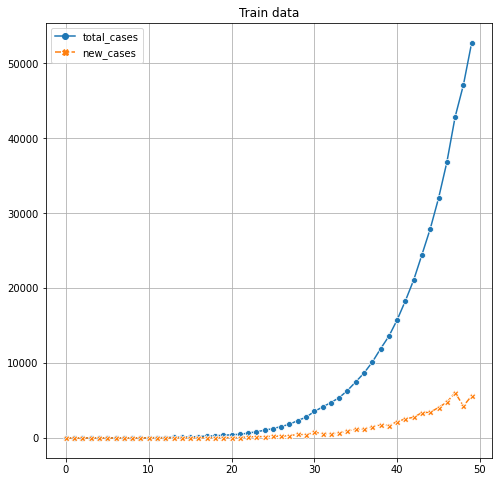

In [5]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
sns.lineplot(
    data=train_df.loc[:, ['total_cases', 'new_cases']],
    markers=True
)
plt.title('Train data')
plt.grid()
plt.show()

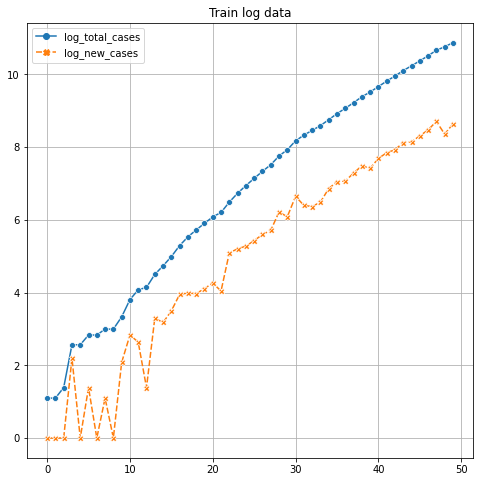

In [6]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
sns.lineplot(
    data=train_df.loc[:, ['log_total_cases', 'log_new_cases']],
    markers=True
)
plt.title('Train log data')
plt.grid()
plt.show()

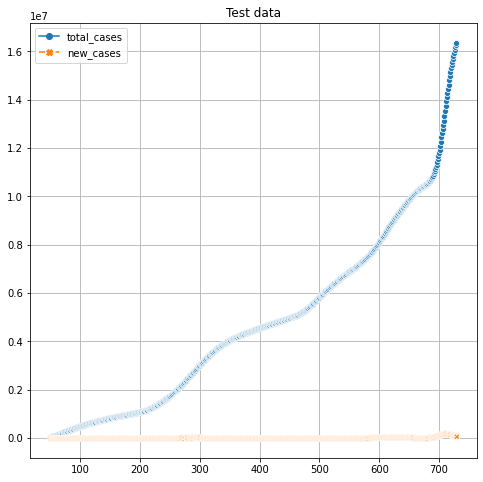

In [7]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
sns.lineplot(
    data=test_df.loc[:, ['total_cases', 'new_cases']],
    markers=True
)
plt.title('Test data')
plt.grid()
plt.show()

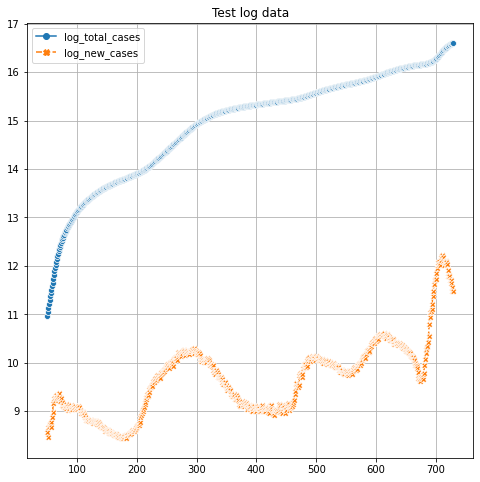

In [8]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
sns.lineplot(
    data=test_df.loc[:, ['log_total_cases', 'log_new_cases']],
    markers=True
)
plt.title('Test log data')
plt.grid()
plt.show()

### 2. Экспоненциальная модель

#### a. Модель с экспоненциальным ростом числа заболевших

Для обучения экспоненциальной модели создаем класс-обертку над линейной моделью

In [9]:
class ExpModel(BaseEstimator):
    
    def __init__(self) -> None:
        self.lin_reg = LinearRegression()
        self.scaler = StandardScaler()
        
    def fit(self, X: np.array, y: np.array) -> None:
        X = self.scaler.fit_transform(X)
        self.lin_reg.fit(X=X, y=np.log(y))
        
    def predict_log(self, X: np.array) -> None:
        X = self.scaler.transform(X)
        prediction = self.lin_reg.predict(X)
        
        return prediction
        
    def predict(self, X: np.array) -> np.array:
        prediction = self.predict_log(X)
        prediction = np.exp(prediction)
        
        return prediction

In [10]:
model = ExpModel()
model.fit(
    X=train_df.index.to_numpy().reshape(-1, 1),
    y=train_df.total_cases.to_numpy()
)

In [11]:
test_df['prediction'] = model.predict(test_df.index.to_numpy().reshape(-1, 1))
test_df['log_prediction'] = model.predict_log(test_df.index.to_numpy().reshape(-1, 1))

Из графика ниже видно, что результаты получились не убедительными: даже на логарифмической шкале наблюдается значительное отклонение

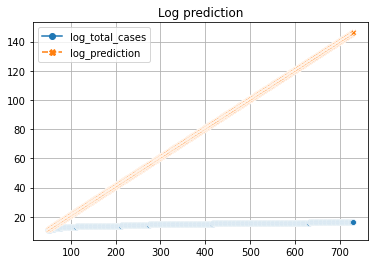

In [12]:
sns.lineplot(
    data=test_df.loc[:, ['log_total_cases', 'log_prediction']],
    markers=True
)
plt.title('Log prediction')
plt.grid()
plt.show()

Из-за быстрого роста экспоненты увеличение `x` ведет к росту ошибки

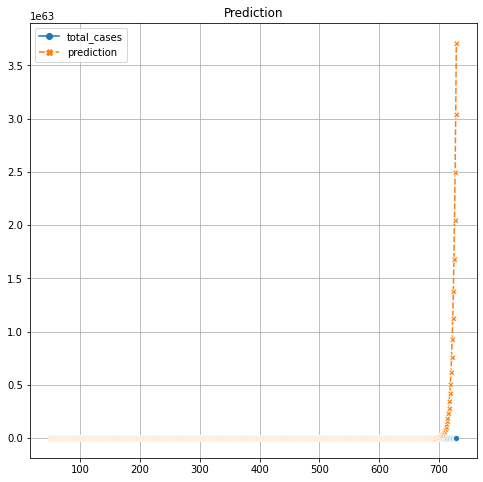

In [13]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
sns.lineplot(
    data=test_df.loc[:, ['total_cases', 'prediction']],
    markers=True
)
plt.title('Prediction')
plt.grid()
plt.show()

Не трудно видеть, что ошибка даже на логарифмической шкале достаточно большая

In [14]:
log_mse = mean_squared_error(test_df.log_total_cases, test_df.log_prediction)
exp_mse = mean_squared_error(test_df.total_cases, test_df.prediction)

print(f'Log MSE: {log_mse}')
print(f'MSE: {exp_mse}')

Log MSE: 5544.419852887642
MSE: 6.1941129156236085e+124


#### b. Поиск апостериорного распределения

Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

Проведя аналитически Байесовский вывод для предложенной модели, были получены следующие результаты:

$$
    \varepsilon \in N(0, \sigma^2) \implies \widetilde y = w^T x + \varepsilon \in N(w^T x, \sigma^2) \implies p_y (x | w) = \frac{1}{x\sigma\sqrt{(2\pi)}} \exp\left( -\frac{{\left(\ln(x) - w^Tx\right)}^2}{2\sigma^2} \right)
$$, где $y = \exp\left(w^Tx + \varepsilon\right) \implies$

$$
    \Sigma_N^{-1} = \Sigma_0^{-1} + \frac{1}{\sigma^2} X^TX
$$
$$
    \mu_N = \Sigma_N\left( \Sigma_0^{-1}\mu_0 + \frac{1}{\sigma^2} X^T\ln(y) \right)
$$

Для расчета оптимальных значений $\alpha$ и $\beta$, где
$$
    p(D | w) = \prod\limits_{n=1}^N N(y_n | w^Tx_n, \frac{1}{\beta})
$$
$$
    p(w) = \prod\limits_{n=1}^M N(w_n | 0, \frac{1}{\alpha})
$$
$$
    p(D | \alpha, \beta) = \frac{M}{2}\ln(\alpha) + \frac{N}{2}\ln(\beta) - \frac{1}{2}\ln(\det(A)) - \frac{N}{2}\ln(2\pi) - \frac{\beta}{2}\sum\limits_{n=1}^N {\left( \ln(y_n) - \mu_N^T x_n \right)}^2 - \frac{\alpha}{2}\mu_N^T\mu_N - \sum\limits_{n=1}^N y_n
$$
где
$$
    \mu_N = \Sigma_N\left( \Sigma_0^{-1}\mu_0 + \frac{1}{\sigma^2} X^T\ln(y) \right)
$$
$$
    \det(\beta X^TX + \alpha I) = \beta^2\left[n\sum\limits_{n=1}^N x_n^2 - {\left(\sum\limits_{n=1}^N\right)}^2\right] + \beta\alpha\left(n + \sum\limits_{n=1}^N x_n^2 \right) + \alpha^2
$$

In [15]:
def get_optimal_pdf_params(alpha_0: float, beta_0: float, X: np.array, y: np.array):
    '''Get optimal alpha and beta'''
    
    def target_function(x):
        '''Function for minimization'''
        
        weights_dim = 2
        data_num = len(X)
        alpha = x[0]
        beta = x[1]
        det_A = beta ** 2 * (data_num * np.sum(list(map(lambda x: x ** 2, X))) - (np.sum(X)) ** 2) + \
            beta * alpha * (data_num + np.sum(list(map(lambda x: x ** 2, X)))) + alpha ** 2
        mu_N, _ = update_bayes(base_mu, base_sigma, X, y, 1 / beta)
        result = -weights_dim / 2 * np.log(alpha) - data_num / 2 * np.log(beta) + \
            np.log(det_A) / 2 + data_num * np.log(2 * np.pi) / 2 + beta / 2 * \
            np.sum([((np.log(y[i]) - mu_N[0] - mu_N[1] * X[i]) ** 2) for i in range(len(X))]) + \
            alpha * (mu_N[0] ** 2 + mu_N[1] ** 2) / 2 + np.sum(y)
        
        return result
    
    base_mu = np.array([0, 0])
    base_sigma = np.matrix([[1 / alpha_0, 0], [0, 1 / alpha_0]])
    res = minimize(target_function, [alpha_0, beta_0])
    optimal_alpha, optimal_beta = res.x
    
    return optimal_alpha, optimal_beta
    

def update_bayes(old_mu: np.array, old_sigma: np.array, X: np.array, y: np.array, sigma_noise: float):
    '''Update bayes sigma and mu matrices accordint to new data'''

    X = np.matrix(X).T
    y = np.matrix(y).T
    old_mu = np.matrix(old_mu).T
    X = np.hstack([np.ones((X.shape[0], 1)), X])
    new_sigma = np.linalg.inv(np.linalg.inv(old_sigma) + 
        (1 / sigma_noise**2) * np.matmul(np.transpose(X), X))
    new_mu = np.matmul(
        new_sigma,
        np.matmul(np.linalg.inv(old_sigma), old_mu) +
            1 / (sigma_noise)**2 * np.matmul(np.transpose(X), np.log(y))
    )
    new_mu = np.array(new_mu.T)[0]
    
    return new_mu, new_sigma


def sample_lines(mu: np.array, sigma: np.array, X: np.array, n:int=20, plot:bool=True):
    '''Plot lines with sampled weights'''
    
    weights_samples = np.random.multivariate_normal(mu, sigma, n)
    y_pred_lst = np.vstack([weights[0] + weights[1] * X for weights in weights_samples])

    if plot:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        plt.grid()

        for y_pred in y_pred_lst:
            plt.plot(X, y_pred, 'k-', lw=.4)
            
    return y_pred_lst

In [16]:
X_train = train_df.index.to_numpy()
y_train = train_df.total_cases.to_numpy()
X_test = test_df.index.to_numpy()
y_test = test_df.total_cases.to_numpy()

alpha_0 = 1
beta_0 = 1
base_mu = np.array([0, 0])
base_sigma = np.matrix([[1 / alpha_0, 0], [0, 1 / alpha_0]])
base_sigma_noise = 2

optimal_alpha, optimal_beta = get_optimal_pdf_params(alpha_0, beta_0, X_train, y_train)
optimal_mu = np.array([0, 0])
optimal_sigma = np.matrix([[1 / optimal_alpha, 0], [0, 1 / optimal_alpha]])
sigma_noise = 1 / optimal_beta

Видим, что без данных разброс прямых большой

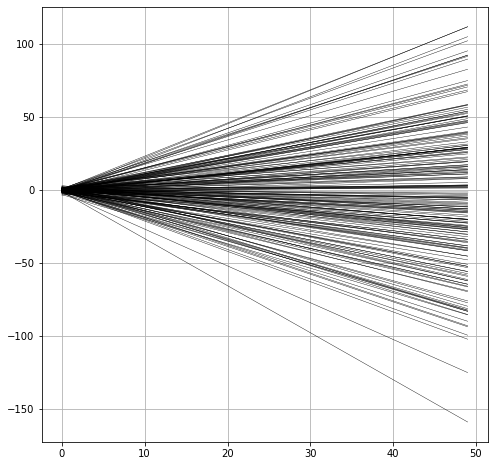

In [17]:
_ = sample_lines(base_mu, base_sigma, X_train, 200)

После обновления $\Sigma_N$ и $\mu_N$ сэмплированные прямы плотно прижимаются к прямой, построенной при помощи линейной регрессии на первом шаге

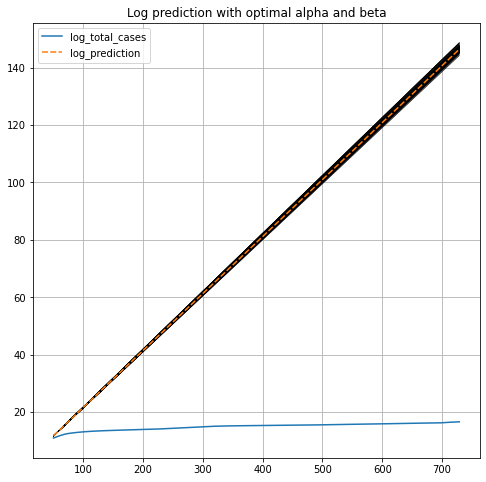

In [18]:
new_mu, new_sigma = update_bayes(optimal_mu, optimal_sigma, X_train, y_train, sigma_noise)
line_samples = sample_lines(new_mu, new_sigma, X_test, 200, plot=True)

sns.lineplot(
    data=test_df.loc[:, ['log_total_cases', 'log_prediction']],
    markers=False
)
plt.title('Log prediction with optimal alpha and beta')
plt.show()

При этом, если выбрать $\alpha$ и $\beta$ случайным образом (без подсчета эмпирического Байеса, как это было сделано выше), то расхождение прямых усиливается, что говорит о том, что оптимальные параметры $\alpha$ и $\beta$ улучшили распределение параметров

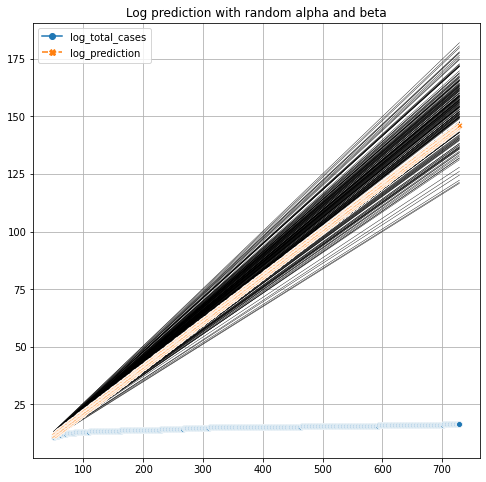

In [19]:
new_mu, new_sigma = update_bayes(base_mu, base_sigma, X_train, y_train, base_sigma_noise)
line_samples = sample_lines(new_mu, new_sigma, X_test, 200, plot=True)

sns.lineplot(
    data=test_df.loc[:, ['log_total_cases', 'log_prediction']],
    markers=True
)
plt.title('Log prediction with random alpha and beta')
plt.show()

#### c. Сэмплирование экспонент

Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

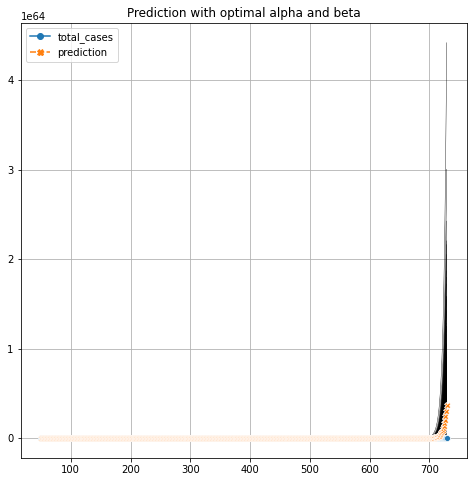

In [20]:
new_mu, new_sigma = update_bayes(optimal_mu, optimal_sigma, X_train, y_train, sigma_noise)
line_samples = sample_lines(new_mu, new_sigma, X_test, 200, plot=False)
exp_lines = [np.exp(line) for line in line_samples]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.grid()

for exp in exp_lines:
    plt.plot(X_test, exp, 'k-', lw=.4)

sns.lineplot(
    data=test_df.loc[:, ['total_cases', 'prediction']],
    markers=True
)
plt.title('Prediction with optimal alpha and beta')
plt.show()

In [21]:
may_idx = data_df.date[data_df.date == '2020-05-01'].index[0]
june_idx = data_df.date[data_df.date == '2020-06-01'].index[0]
sep_idx = data_df.date[data_df.date == '2020-09-01'].index[0]

Далее сэмплируем предсказания из полученного распределения

In [22]:
may_samples_lst = sample_lines(new_mu, new_sigma, np.array([may_idx]), 1000, plot=False)
june_samples_lst = sample_lines(new_mu, new_sigma, np.array([june_idx]), 1000, plot=False)
sep_samples_lst = sample_lines(new_mu, new_sigma, np.array([sep_idx]), 1000, plot=False)

In [23]:
def plot_prediction_distribution(samples: list, name: str, true_total: float):
    '''Plot prediction distribution'''
    
    samples = np.exp(samples)
    sns.histplot(samples)
    plt.legend([f'1 {name}'])
    plt.title(f'1 {name} prediction distribution')
    plt.show()

    print(f"Mean: {np.mean(samples)}")
    print(f"Std: {np.std(samples)}")
    print(f"Prediction: {np.round(np.mean(samples))}")
    print(f"True total: {true_total}")

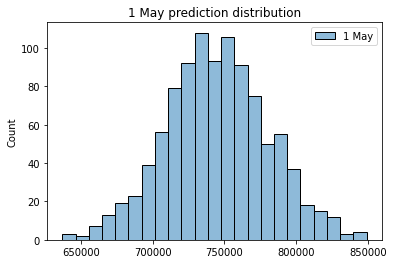

Mean: 744901.3996847193
Std: 35667.43648092737
Prediction: 744901.0
True total: 114431.0


In [24]:
plot_prediction_distribution(may_samples_lst, 'May', data_df.total_cases[may_idx])

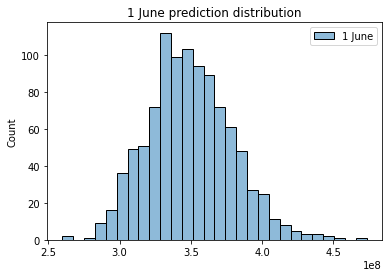

Mean: 349190150.2913165
Std: 29589885.42851609
Prediction: 349190150.0
True total: 414328.0


In [25]:
plot_prediction_distribution(june_samples_lst, 'June', data_df.total_cases[june_idx])

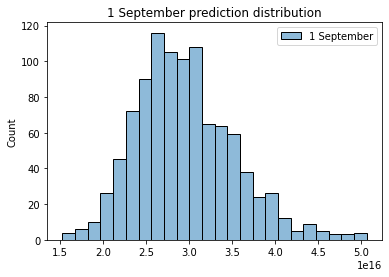

Mean: 2.9488521624995308e+16
Std: 5724983937987633.0
Prediction: 2.9488521624995308e+16
True total: 997072.0


In [26]:
plot_prediction_distribution(sep_samples_lst, 'September', data_df.total_cases[sep_idx])

Из данных выше видим, что результаты предсказания модели сильно отличаются от реальных данных. При этом, чем дальше удаляемся по оси `x` от `X_train`, тем сильнее отклонение от наблюдаемых данных из-за быстрого роста экспоненты.

### 3. Модель сигмоида

$$
    F(x) = \widetilde w_3 \frac{2}{\sqrt{\pi}} \int\limits_{-\inf}^{x} \exp(-{(w_1 t + w_2)}^2) dt = w_3 \frac{2}{\sqrt{\pi}} \int\limits_{-\inf}^{w_1 x + w_2} \exp(-t^2) dt = w_3 \Phi\left(w_1 x + w_2\right)
$$

Модель: $y = w_3 \Phi\left(w_1 x + w_2\right) + \varepsilon$, $\varepsilon \in N(0, \frac{1}{\alpha})$ следовательно $y \in N\left(w_3 \Phi\left(w_1 x + w_2\right), \frac{1}{\alpha}\right)$. Также $p(w) = N\left(0, \frac{1}{\beta} I\right)$.


#### a. Обучение параметров при помощи линейной регрессии

Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.


In [27]:
def optim_func(w, X, y):
    
    F_func = lambda x: stats.norm.cdf(w[0] * x + w[1]) * w[2]
    res = np.sum([ ((y[i] - F_func(X[i])) ** 2) for i in range(len(y)) ])
    
    return res

res = minimize(lambda weights: optim_func(weights, X_train, y_train), [1, 1, 1000], tol=1e-3)
weights = res.x
F_func = lambda x: stats.norm.cdf(weights[0] * x + weights[1]) * weights[2]
train_df['sigmoid_pred'] = list(F_func(X_train))
test_df['sigmoid_pred'] = list(F_func(X_test))

Обучив модель, видим, что модель достаточно хорошо подстроилась под обучающую выборку

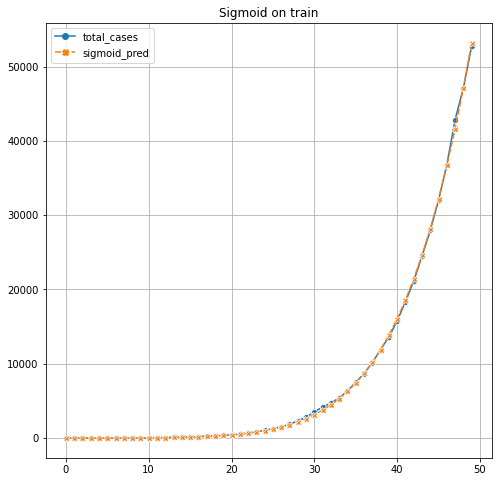

In [28]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
sns.lineplot(
    data=train_df.loc[:, ['total_cases', 'sigmoid_pred']],
    markers=True
)
plt.title('Sigmoid on train')
plt.grid()
plt.show()

При этом, на тесте видно, что сигмоида слишком ограничена сверху, из-за чего после `x=200` расхождение в предсказаниях и реальных данных сильно увеличивается. Частично это связано с тем, что тренировочный набор достаточно маленький, из-за чего модель не может предсказать динамику данных на большом горизонте.

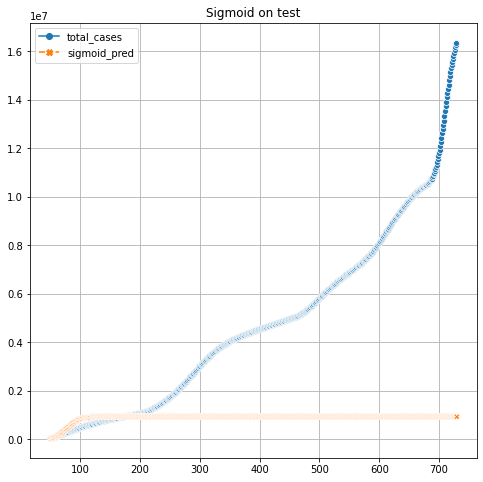

In [29]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
sns.lineplot(
    data=test_df.loc[:, ['total_cases', 'sigmoid_pred']],
    markers=True
)
plt.title('Sigmoid on test')
plt.grid()
plt.show()

Если изучить график с train и test данными вместе, то видно, что тренировочные данные модель приближает достаточно хорошо. До $x=200$ тестовые данные также относительно неплохо приближаются. Но далее наблюдается существенное расхождение между предсказаниями и наблюдениями

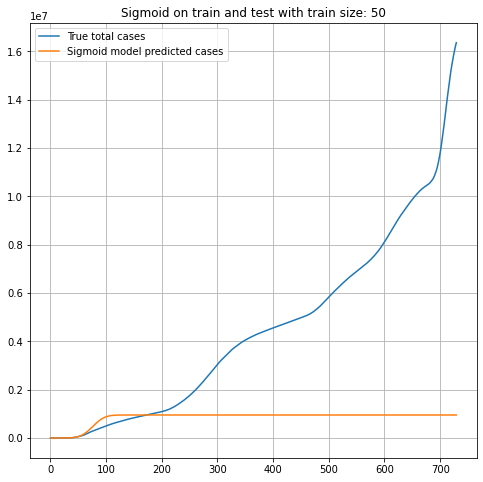

In [30]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
sns.lineplot(
    x=np.concatenate([X_train, X_test]),
    y=np.concatenate([y_train, y_test]),
    markers=True
)
sns.lineplot(
    x=np.concatenate([X_train, X_test]),
    y=np.concatenate([F_func(X_train), F_func(X_test)]),
    markers=True
)
plt.title(f'Sigmoid on train and test with train size: {TRAIN_SIZE}')
plt.legend(['True total cases', 'Sigmoid model predicted cases'])
plt.grid()
plt.show()

In [31]:
def likelihood(weights: np.array, X: np.array, y: np.array, alpha: float):
    '''p(D | w)'''
    
    F_func = lambda x: stats.norm.cdf(weights[0] * x + weights[1]) * weights[2]
    norm_pdf = lambda x, y: stats.norm.pdf(y, loc=F_func(x), scale=1/alpha)
    res = np.prod([ norm_pdf(X[i], y[i]) for i in range(len(y)) ])
    print(res)
    
    return res


def prior(weights: np.array, beta: float):
    '''p(w)'''
    
    print(res)
    
    res = stats.multivariate_normal.pdf(weights, mean=[0, 0, 0], cov=np.eye(3)/beta)

In [32]:
def acceptance_ratio(current_weights, new_weights):
    res = min(1, ((likelihood(new_weights, X_train, y_train, alpha) / \
                   likelihood(current_weights, X_train, y_train, alpha)) * \
                  (prior(new_weights, beta) / prior(current_weights, beta))))
    return res

### 4. Анализ других стран

Далее проведем аналогиченый анализ по данным США

In [33]:
TRAIN_SIZE = 100
ZERO_NEW_CASES_FILL = 2

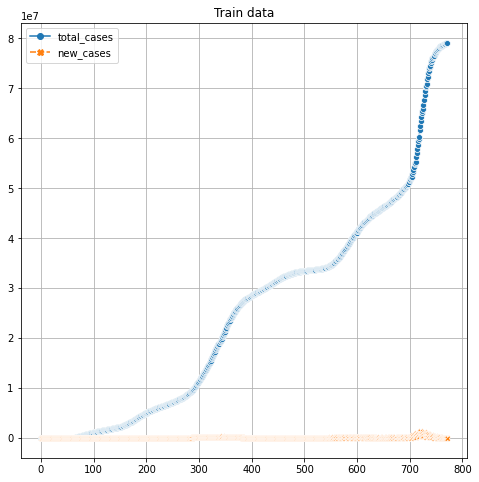

Дата, начиная с которой общее число столо больше 2: 2020-01-24


In [34]:
data_df = pd.read_csv(os.path.join('data', 'owid-covid-data.csv'), usecols=['date', 'total_cases', 'new_cases', 'iso_code'])
data_df = data_df[data_df.iso_code == 'USA'].copy()
data_df.reset_index(drop=True, inplace=True)
start_index = data_df[data_df.total_cases >= 2].index[0]
START_DATE = data_df.date[start_index]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
sns.lineplot(
    data=data_df.loc[data_df.index[:1000], ['total_cases', 'new_cases']],
    markers=True
)
plt.title('Train data')
plt.grid()
plt.show()
print(f"Дата, начиная с которой общее число столо больше 2: {START_DATE}")

In [35]:
data_df.date = data_df.date.map(datetime.fromisoformat)
data_df.new_cases = data_df.new_cases.mask(data_df.new_cases == 0, ZERO_NEW_CASES_FILL)
data_df = data_df[data_df.date >= datetime.fromisoformat(START_DATE)]
data_df.reset_index(drop=True, inplace=True)
data_df['log_new_cases'] = np.log(data_df.new_cases)
data_df['log_total_cases'] = np.log(data_df.total_cases)
data_df

,iso_code,date,total_cases,new_cases,log_new_cases,log_total_cases
0,USA,2020-01-24,2.0,1.0,0.000000,0.693147
1,USA,2020-01-25,2.0,2.0,0.693147,0.693147
2,USA,2020-01-26,5.0,3.0,1.098612,1.609438
3,USA,2020-01-27,5.0,2.0,0.693147,1.609438
4,USA,2020-01-28,5.0,2.0,0.693147,1.609438
...,...,...,...,...,...,...
764,USA,2022-02-26,78929797.0,48638.0,10.792160,18.184069
765,USA,2022-02-27,78947866.0,18069.0,9.801953,18.184298
766,USA,2022-02-28,79044330.0,96464.0,11.476925,18.185519
767,USA,2022-03-01,79091361.0,47031.0,10.758562,18.186114


In [36]:
train_df = data_df[data_df.index < TRAIN_SIZE].copy()
test_df = data_df[(data_df.index >= TRAIN_SIZE)].copy()

print(f'Train size: {train_df.shape[0]}')
print(f'Test size: {test_df.shape[0]}')

Train size: 100
Test size: 669


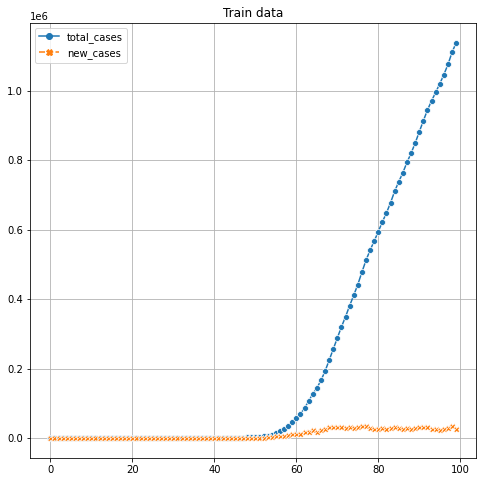

In [37]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
sns.lineplot(
    data=train_df.loc[:, ['total_cases', 'new_cases']],
    markers=True
)
plt.title('Train data')
plt.grid()
plt.show()

Из графика ниже уже видно, что рост данных происходит не по экспоненте. Тем не менее, посмотрим на результаты работы модели

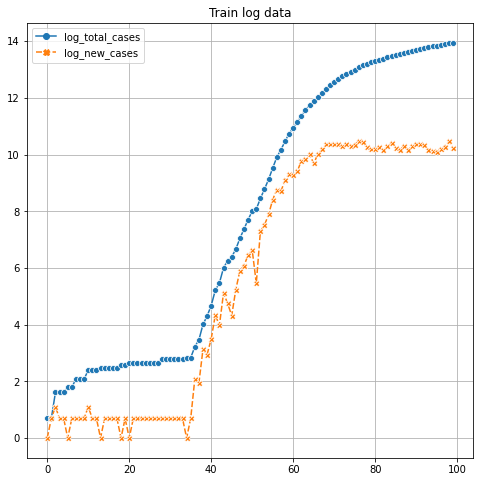

In [38]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
sns.lineplot(
    data=train_df.loc[:, ['log_total_cases', 'log_new_cases']],
    markers=True
)
plt.title('Train log data')
plt.grid()
plt.show()

In [39]:
X_train = train_df.index.to_numpy()
y_train = train_df.total_cases.to_numpy()
X_test = test_df.index.to_numpy()
y_test = test_df.total_cases.to_numpy()

alpha_0 = 0.2
beta_0 = 0.1
base_mu = np.array([0, 0])
base_sigma = np.matrix([[1 / alpha_0, 0], [0, 1 / alpha_0]])
base_sigma_noise = 2

optimal_alpha, optimal_beta = get_optimal_pdf_params(alpha_0, beta_0, X_train, y_train)
optimal_mu = np.array([0, 0])
optimal_sigma = np.matrix([[1 / optimal_alpha, 0], [0, 1 / optimal_alpha]])
sigma_noise = 1 / optimal_beta

In [40]:
model = ExpModel()
model.fit(
    X=train_df.index.to_numpy().reshape(-1, 1),
    y=train_df.total_cases.to_numpy()
)
test_df['prediction'] = model.predict(test_df.index.to_numpy().reshape(-1, 1))
test_df['log_prediction'] = model.predict_log(test_df.index.to_numpy().reshape(-1, 1))

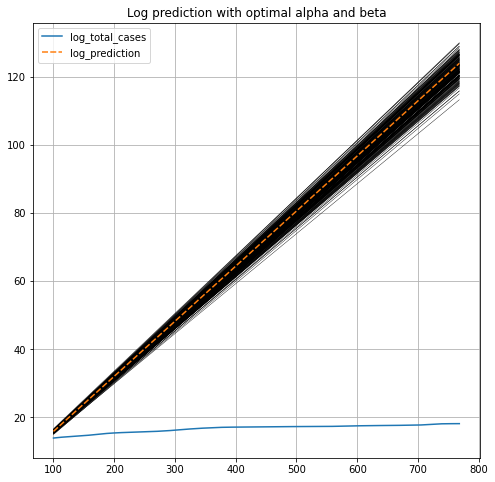

In [41]:
new_mu, new_sigma = update_bayes(optimal_mu, optimal_sigma, X_train, y_train, sigma_noise)
line_samples = sample_lines(new_mu, new_sigma, X_test, 200, plot=True)

sns.lineplot(
    data=test_df.loc[:, ['log_total_cases', 'log_prediction']],
    markers=False
)
plt.title('Log prediction with optimal alpha and beta')
plt.show()

In [42]:
may_idx = data_df.date[data_df.date == '2020-05-01'].index[0]
june_idx = data_df.date[data_df.date == '2020-06-01'].index[0]
sep_idx = data_df.date[data_df.date == '2020-09-01'].index[0]
may_samples_lst = sample_lines(new_mu, new_sigma, np.array([may_idx]), 1000, plot=False)
june_samples_lst = sample_lines(new_mu, new_sigma, np.array([june_idx]), 1000, plot=False)
sep_samples_lst = sample_lines(new_mu, new_sigma, np.array([sep_idx]), 1000, plot=False)

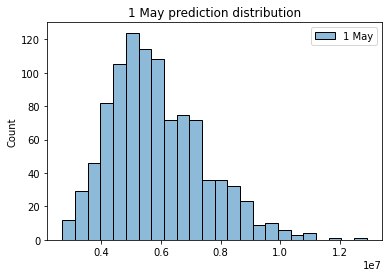

Mean: 5868532.0185309285
Std: 1580044.772284863
Prediction: 5868532.0
True total: 1110675.0


In [43]:
plot_prediction_distribution(may_samples_lst, 'May', data_df.total_cases[may_idx])

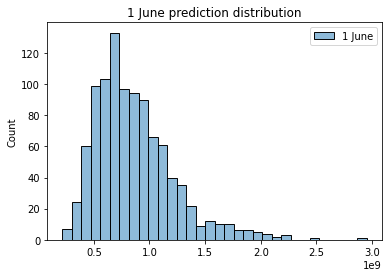

Mean: 861855313.4419489
Std: 356846976.8109797
Prediction: 861855313.0
True total: 1804735.0


In [44]:
plot_prediction_distribution(june_samples_lst, 'June', data_df.total_cases[june_idx])

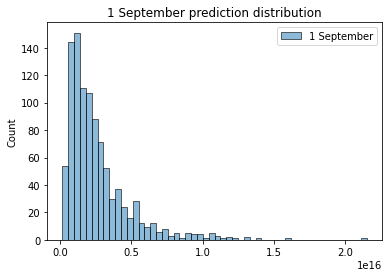

Mean: 2614129197860928.5
Std: 2251029564478762.8
Prediction: 2614129197860928.0
True total: 6085900.0


In [45]:
plot_prediction_distribution(sep_samples_lst, 'September', data_df.total_cases[sep_idx])

Результаты исследования данных для США аналогичны результатам для РФ: экспоненциальная модель плохо справляется с задачей предсказания на большом горизонте из-за большой скорости роста. Разброс сэмплов можно регулировать изменяя гиперпараметры априорного распределения, но для получения достаточно хороших результатов можно использовать численный метод оценки параметров $\alpha$ и $\beta$.